## Spotify App Reviews
##### Nadav Yedid

- [Link to the DataSet on Kaggle.](https://www.kaggle.com/datasets/mfaaris/spotify-app-reviews-2022)

In [1]:
#!pip install transformers
#!pip install torch

In [2]:
import torch

# Check for GPU and assign device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using device:", device)

Using device: cuda


---
1) [Introducing the Data.](#section1)
2) [NaN values.](#section2)
3) [Convert ratings.](#section3)
4) [ Clearing the text.](#section4)
5) [Division into Train, Validation and Test.](#section5)
6) [Loading the Tokenizer and preparing the texts.](#section6)
7) [Creating a Dataset for PyTorch.](#section7)
8) [Model definition and training.](#section8)
9) [Optimizer and Learning rate.](#section9)
10) [Training the model.](#section10)
11) [Model validation.](#section11)
12) [Saving the Fine-Tuned Model.](#section12)

---
<a id = "section1"></a>
### <span style = "color:blue" >1) Introducing the Data: </span>

In [3]:
import pandas as pd
url = "https://raw.githubusercontent.com/NadavYedid/Bert-Sentiment-Analysis-App-Reviews/refs/heads/main/SpotifyAppReviews.csv"

data = pd.read_csv(url)
spotify_df = data.copy()

In [4]:
spotify_df.tail()

,Time_submitted,Review,Rating,Total_thumbsup,Reply
61589,2022-01-01 03:01:29,Even though it was communicated that lyrics fe...,1,6,NaN
61590,2022-01-01 02:13:40,"Use to be sooo good back when I had it, and wh...",1,0,NaN
61591,2022-01-01 01:02:29,This app would be good if not for it taking ov...,2,10,NaN
61592,2022-01-01 00:49:23,The app is good hard to navigate and won't jus...,2,1,NaN
61593,2022-01-01 00:19:09,Its good but sometimes it doesnt load the musi...,4,0,NaN


## Dataset Overview

The dataset contains user reviews of mobile applications from the Google Play Store.  
It includes the following columns:

- **Time_submitted**: Timestamp when the review was posted.
- **Review**: The text content of the user review.
- **Rating**: A numeric score from 1 (worst) to 5 (best).
- **Total_thumbsup**: Number of likes/upvotes the review received.
- **Reply**: Developer’s response to the review (if any).

We will derive a new column called `Sentiment` based on the rating:
- 1–2 → Negative  
- 4–5 → Positive  
- 3 → Neutral (removed from dataset)

Another column `Clean_Review` will contain the preprocessed text.

---
<a id = "section2"></a>
### <span style = "color:blue" > 2) NaN values: </span>

In [5]:
spotify_df.isnull().sum()

,0
Time_submitted,0
Review,0
Rating,0
Total_thumbsup,0
Reply,61378


#### Removing rows with missing values in 'Review' or 'Rating' columns

In [6]:
spotify_df.drop(columns=["Reply"], inplace=True)
spotify_df = spotify_df.dropna(subset = ['Review', 'Rating'])
spotify_df.tail()

,Time_submitted,Review,Rating,Total_thumbsup
61589,2022-01-01 03:01:29,Even though it was communicated that lyrics fe...,1,6
61590,2022-01-01 02:13:40,"Use to be sooo good back when I had it, and wh...",1,0
61591,2022-01-01 01:02:29,This app would be good if not for it taking ov...,2,10
61592,2022-01-01 00:49:23,The app is good hard to navigate and won't jus...,2,1
61593,2022-01-01 00:19:09,Its good but sometimes it doesnt load the musi...,4,0


---
<a id = "section3"></a>
### <span style = "color:blue" > 3) Convert ratings: </span>

#### A rating of 3 is considered neutral.

In [7]:
def label_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating >= 4:
        return 'positive'
    else:
        return None

#### Create a 'Sentiment' column and removing rows with neutral sentiment:

In [8]:
spotify_df['Sentiment'] = spotify_df['Rating'].apply(label_sentiment)

spotify_df = spotify_df.dropna(subset = ['Sentiment'])

---
<a id = "section4"></a>
### <span style = "color:blue" > 4) Clearing the text: </span>

In [9]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

In [10]:
spotify_df['Clean_Review'] = spotify_df['Review'].apply(clean_text)

---
<a id = "section5"></a>
### <span style = "color:blue" > 5) Division into Train, Validation and Test: </span>

### First stage: Division into Train (80%) and Test (20%)

In [11]:
from sklearn.model_selection import train_test_split

train_val_df, test_df = train_test_split(spotify_df, test_size=0.2, random_state=42, stratify=spotify_df['Sentiment'])

### Second step: From the Train, we divide 20% for Validation
#### Stratify - Ensures that we maintain a positive/negative ratio in each group

In [12]:
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['Sentiment'])

### Distribution check

In [13]:
print("Train Sentiment Distribution:")
print(train_df['Sentiment'].value_counts())

print("\nValidation Sentiment Distribution:")
print(val_df['Sentiment'].value_counts())

print("\nTest Sentiment Distribution:")
print(test_df['Sentiment'].value_counts())

Train Sentiment Distribution:
Sentiment
positive    19159
negative    15853
Name: count, dtype: int64

Validation Sentiment Distribution:
Sentiment
positive    4790
negative    3964
Name: count, dtype: int64

Test Sentiment Distribution:
Sentiment
positive    5988
negative    4954
Name: count, dtype: int64


In [14]:
print(f"Total data size: {len(spotify_df)}")
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Total data size: 54708
Train size: 35012
Validation size: 8754
Test size: 10942


---
<a id = "section6"></a>
### <span style = "color:blue" > 6) Loading the Tokenizer and preparing the texts: </span>

In [15]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Data Tokenization:

In [16]:
def tokenize_data(texts, labels, tokenizer, max_len = 128):
    encoding = tokenizer(
        texts.tolist(),
        truncation = True,
        padding = True,
        max_length = max_len,
        return_tensors = 'pt')

    label_map = {'positive': 1, 'negative': 0}
    labels_tensor = [label_map[label] for label in labels]
    return encoding, labels_tensor

In [17]:
train_encodings, train_labels = tokenize_data(train_df['Clean_Review'], train_df['Sentiment'], tokenizer)
val_encodings, val_labels = tokenize_data(val_df['Clean_Review'], val_df['Sentiment'], tokenizer)
test_encodings, test_labels = tokenize_data(test_df['Clean_Review'], test_df['Sentiment'], tokenizer)

---
<a id = "section7"></a>
### <span style = "color:blue" > 7) Creating a Dataset for PyTorch: </span>

In [18]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

In [19]:
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

---
<a id = "section8"></a>
### <span style = "color:blue" > 8) Model definition and training: </span>

In [20]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels = 2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Define model path as a constant
MODEL_PATH = "best_model.pt"

---
<a id = "section9"></a>
### <span style = "color:blue" > 9) Optimizer and Learning rate: </span>

In [22]:
from torch.optim import AdamW
from transformers import get_scheduler

optimizer = AdamW(model.parameters(), lr = 5e-5)
num_epochs = 10

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler("linear",
    optimizer = optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps,)

### Choosing a GPU for the model:

In [23]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

---
<a id = "section10"></a>
### <span style = "color:blue" > 10) Training the model: </span>


### Initialize variables for EarlyStopping

In [24]:
best_val_loss = float('inf')
patience = 2
early_stop_counter = 0

In [25]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# === Initialize EarlyStopping ===

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    loop = tqdm(train_dataloader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item())

    # === Training metrics ===
    train_loss = total_loss / len(train_dataloader)
    train_acc = accuracy_score(all_labels, all_preds)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # === Validation ===
    model.eval()
    val_loss, val_preds, val_labels = 0, [], []
    with torch.no_grad():
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss += outputs.loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch['labels'].cpu().numpy())

    val_loss /= len(val_dataloader)
    val_acc = accuracy_score(val_labels, val_preds)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

        # === EarlyStopping ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_PATH)
        print("Validation loss improved. Saving model.")
    else:
        early_stop_counter += 1
        print(f"⏸ No improvement in validation loss for {early_stop_counter} epoch(s).")
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    model.train()


Epoch 1/10


Epoch 1: 100%|██████████| 1095/1095 [11:18<00:00,  1.61it/s, loss=0.157]


Train Loss: 0.2540 | Train Acc: 0.9001
Val   Loss: 0.2270 | Val   Acc: 0.9134
Validation loss improved. Saving model.

Epoch 2/10


Epoch 2: 100%|██████████| 1095/1095 [11:28<00:00,  1.59it/s, loss=0.00668]


Train Loss: 0.1814 | Train Acc: 0.9333
Val   Loss: 0.2429 | Val   Acc: 0.9078
⏸ No improvement in validation loss for 1 epoch(s).

Epoch 3/10


Epoch 3: 100%|██████████| 1095/1095 [11:27<00:00,  1.59it/s, loss=0.416]


Train Loss: 0.1200 | Train Acc: 0.9584
Val   Loss: 0.2529 | Val   Acc: 0.9055
⏸ No improvement in validation loss for 2 epoch(s).
Early stopping triggered.


### Plot training and validation loss & accuracy

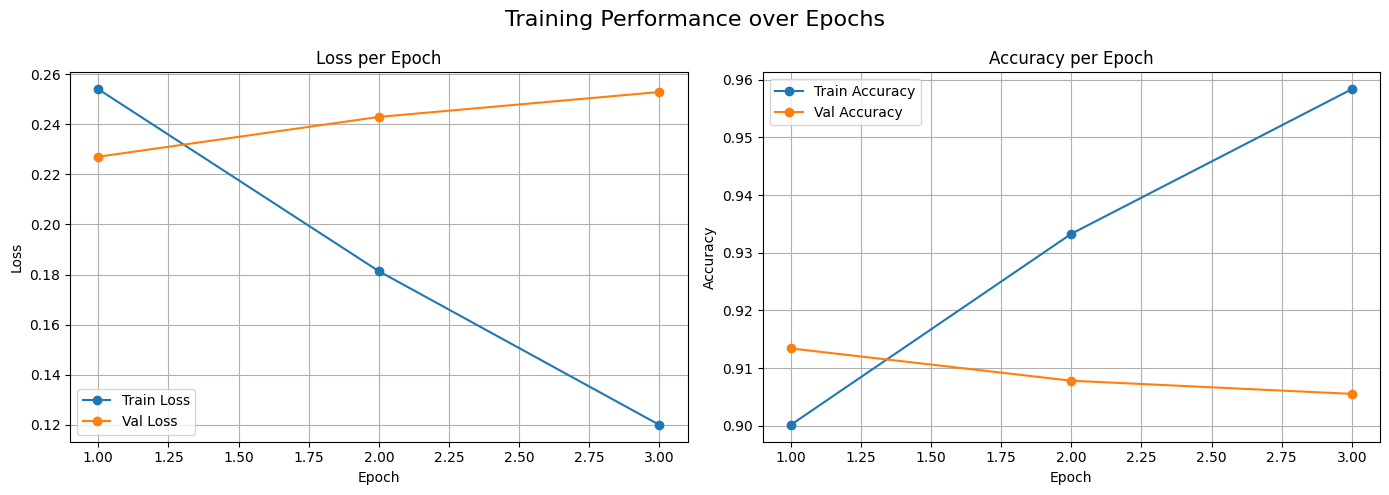

In [26]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))
plt.suptitle("Training Performance over Epochs", fontsize=16)

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, val_accuracies, label='Val Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

---
<a id = "section11"></a>
### <span style = "color:blue" > 11) Model evaluation: </span>

In [27]:
from sklearn.metrics import classification_report

def evaluate(model, dataloader, dataset_name = "Validation"):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    print(f"\n{dataset_name} Results:")
    print(classification_report(true_labels, predictions, target_names = ["Negative", "Positive"]))

In [28]:
evaluate(model, val_dataloader, "Validation")
evaluate(model, test_dataloader, "Test")


Validation Results:
              precision    recall  f1-score   support

    Negative       0.90      0.89      0.89      3964
    Positive       0.91      0.92      0.91      4790

    accuracy                           0.91      8754
   macro avg       0.91      0.90      0.90      8754
weighted avg       0.91      0.91      0.91      8754


Test Results:
              precision    recall  f1-score   support

    Negative       0.91      0.90      0.90      4954
    Positive       0.92      0.93      0.92      5988

    accuracy                           0.91     10942
   macro avg       0.91      0.91      0.91     10942
weighted avg       0.91      0.91      0.91     10942



In [31]:
model.eval()
val_loss, val_preds, val_labels = 0, [], []

with torch.no_grad():
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        val_loss += outputs.loss.item()
        preds = torch.argmax(outputs.logits, dim=1)
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(batch['labels'].cpu().numpy())

val_loss /= len(val_dataloader)
val_acc = accuracy_score(val_labels, val_preds)
val_losses.append(val_loss)
val_accuracies.append(val_acc)

print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")


Train Loss: 0.1200 | Train Acc: 0.9584
Val   Loss: 0.2529 | Val   Acc: 0.9055


### Training Metrics Visualization


In [32]:
from sklearn.metrics import accuracy_score
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    loop = tqdm(train_dataloader, leave = True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        preds = torch.argmax(outputs.logits, dim = 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

        loop.set_description(f"Epoch {epoch + 1}")
        loop.set_postfix(loss=loss.item())

    train_loss = total_loss / len(train_dataloader)
    train_acc = accuracy_score(all_labels, all_preds)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # EarlyStopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Optional: save the best model
    else:
        early_stop_counter += 1
        print(f"No improvement in validation loss for {early_stop_counter} epoch(s).")
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/10


Epoch 1: 100%|██████████| 1095/1095 [11:28<00:00,  1.59it/s, loss=0.0256]

No improvement in validation loss for 3 epoch(s).
Early stopping triggered.


### Confusion Matrix

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.eval()
test_preds, test_labels_flat = [], []
with torch.no_grad():
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels_flat.extend(batch['labels'].cpu().numpy())

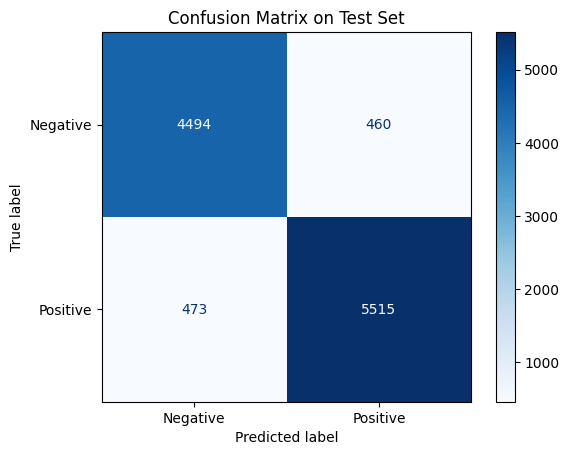

In [34]:
cm = confusion_matrix(test_labels_flat, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.show()

---
<a id = "section12"></a>
### <span style = "color:blue" > 12) Saving the Fine-Tuned Model: </span>

In [35]:
from transformers import BertForSequenceClassification

best_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

best_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
best_model.to(device)
best_model.eval()

print("Loaded the best saved model from best_model.pt and set to evaluation mode.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded the best saved model from best_model.pt and set to evaluation mode.


### Final Evaluation and Visualization

In [36]:
from sklearn.metrics import classification_report

def evaluate(model, dataloader, dataset_name="Validation"):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    print(f"\n{dataset_name} Results:")
    print(classification_report(true_labels, predictions, target_names=["Negative", "Positive"]))

In [37]:
evaluate(best_model, val_dataloader, 'Validation')
evaluate(best_model, test_dataloader, 'Test')


Validation Results:
              precision    recall  f1-score   support

    Negative       0.90      0.91      0.91      3964
    Positive       0.93      0.91      0.92      4790

    accuracy                           0.91      8754
   macro avg       0.91      0.91      0.91      8754
weighted avg       0.91      0.91      0.91      8754


Test Results:
              precision    recall  f1-score   support

    Negative       0.90      0.92      0.91      4954
    Positive       0.93      0.92      0.92      5988

    accuracy                           0.92     10942
   macro avg       0.92      0.92      0.92     10942
weighted avg       0.92      0.92      0.92     10942



### Predicting Sentiment for New User Input

In [38]:
def predict_sentiment(text, model, tokenizer, max_len=128):
    model.eval()
    cleaned_text = re.sub(r'[^a-z0-9\s]', '', text.lower())
    inputs = tokenizer(
        cleaned_text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=max_len)

    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()
    return "Positive" if prediction == 1 else "Negative"

# Example usage:
user_input = "This app is fantastic! I love using it every day."
prediction = predict_sentiment(user_input, best_model, tokenizer)
print(f"Input: {user_input}\n Predicted Sentiment: {prediction}")

Input: This app is fantastic! I love using it every day.
 Predicted Sentiment: Positive
